In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import SparseRandomProjection
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, roc_auc_score, \
                            roc_curve, auc, scorer, classification_report, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, \
                             learning_curve, validation_curve
from scipy.stats import kurtosistest, kurtosis
import timeit

In [4]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.dropna(inplace=True)
df.drop(columns='customerID', inplace=True)
df.Churn = df.Churn.map({'Yes':1, 'No':0})
df = pd.get_dummies(df)
df.shape

(7032, 46)

In [5]:
y = df.Churn.values
X = df.drop(columns='Churn')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5274, 45) (1758, 45) (5274,) (1758,)


In [6]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Anaconda2\envs\dva\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Part1 Clustering

### KM

In [7]:
def find_km_metrics(xtrain, ytrain, clusters):

    wssse = {}
    labels = {}
    silhouette = {}
    mutual_info = {}
    
    for c in clusters:
        km = KMeans(n_clusters=c, n_init=10, random_state=1, n_jobs=-1)
        label = km.fit_predict(xtrain)
        wssse[c] = km.inertia_
        labels[c] = label
        if c > 1:
            silhouette[c] = silhouette_score(xtrain, label, random_state=1)
        mutual_info[c] = adjusted_mutual_info_score(ytrain, label, average_method='arithmetic')
        
    return wssse, labels, silhouette, mutual_info

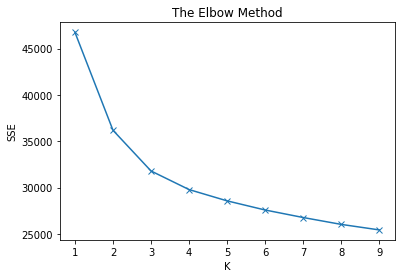

In [8]:
# sum of squared distances to closest cluster centers
clusters = range(1, 10)
wssse, labels, silhouette, mutual_info = find_km_metrics(X_train_scaled, y_train, clusters)

# Plot SSE for each *k*

plt.title('The Elbow Method')
plt.xlabel('K'); 
plt.ylabel('SSE')
plt.xticks(clusters)
plt.plot(wssse.keys(), wssse.values(), 'x-')

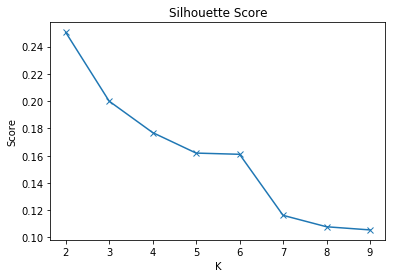

In [9]:
plt.title('Silhouette Score')
plt.xlabel('K'); 
plt.ylabel('Score')
plt.xticks(clusters)
plt.plot(silhouette.keys(), silhouette.values(), 'x-')

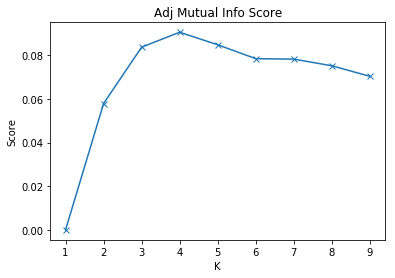

In [10]:
plt.title('Adj Mutual Info Score')
plt.xlabel('K'); 
plt.ylabel('Score')
plt.xticks(clusters)
plt.plot(mutual_info.keys(), mutual_info.values(), 'x-')

### Validate clustering

In [11]:
from mpl_toolkits.mplot3d import Axes3D

In [12]:
# print cumulated explained_variance_ratio
def find_cumulated_explained_var(pca):
    return np.cumsum(np.round(pca.explained_variance_ratio_, decimals=6)*100)

In [13]:
pca_viz = PCA(n_components=3, random_state=1)
X_viz = pca_viz.fit_transform(X_train_scaled)
features = X_viz.T

find_cumulated_explained_var(pca_viz)

array([23.4982, 37.2844, 45.7743])

Text(0.5, 0.92, 'Plot using true labels')

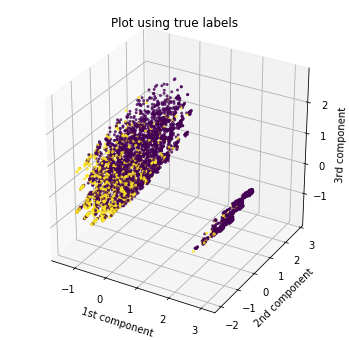

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(features[0], features[1], features[2], c=y_train, alpha=0.7, s=4, cmap='viridis')
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')
ax.set_title('Plot using true labels')

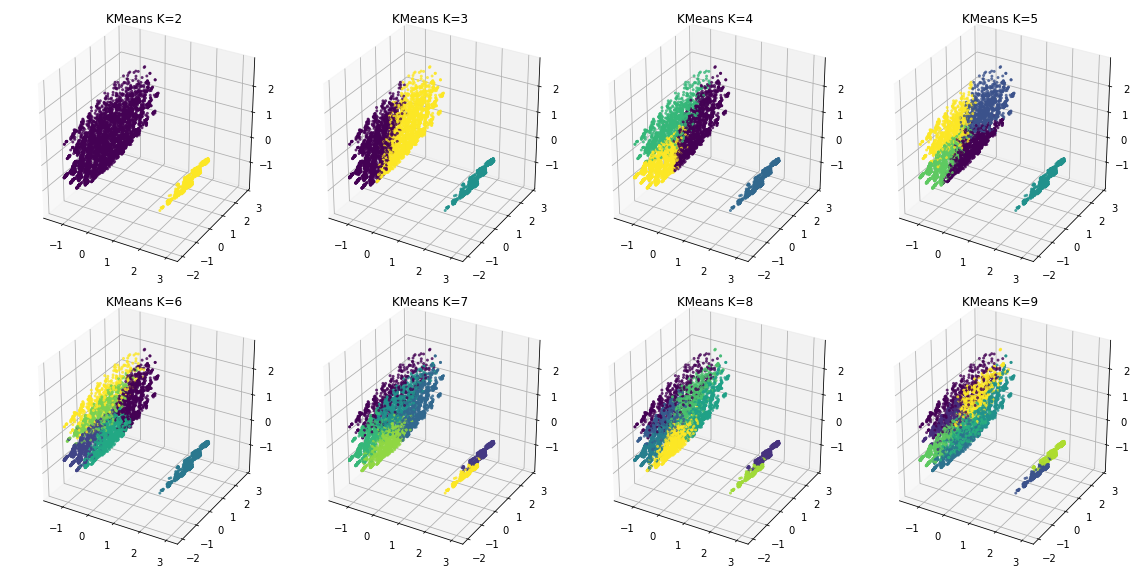

In [15]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('KMeans K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### GMM

In [16]:
def find_gmm_bic_all(cotype, xtrain, clusters):

    bic = {}
    for t in cotype:
        for c in clusters:
            gmm = GaussianMixture(n_components=c, covariance_type=t, n_init=10, random_state=1)
            cluster_labels = gmm.fit_predict(xtrain)
            bic[(t, c)] = gmm.bic(xtrain)
    return bic

In [17]:
cotype = ['full', 'tied', 'diag', 'spherical']

bic = find_gmm_bic_all(cotype, X_train_scaled, clusters)

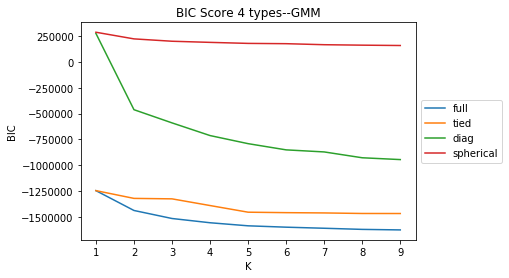

In [18]:
plt.title('BIC Score 4 types--GMM')
plt.xlabel('K')
plt.ylabel('BIC')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [19]:
def find_gmm_metrics(xtrain, ytrain, clusters):

    labels = {}
    bic = {}
    silhouette = {}
    mutual_info = {}
    for c in clusters:
        gmm = GaussianMixture(n_components=c, covariance_type='full', n_init=10, random_state=1)
        label = gmm.fit_predict(xtrain)
        bic[c] = gmm.bic(xtrain)
        labels[c] = label
        if c > 1:
            silhouette[c] = silhouette_score(xtrain, label, random_state=1)
        mutual_info[c] = adjusted_mutual_info_score(ytrain, label, average_method='arithmetic')
    return bic, labels, silhouette, mutual_info

In [20]:
bic, labels, silhouette, mutual_info = find_gmm_metrics(X_train_scaled, y_train, clusters)

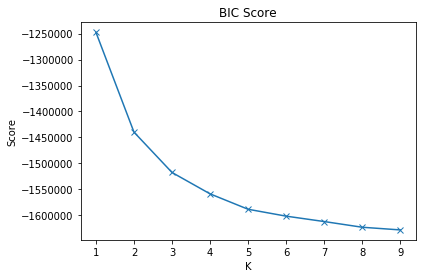

In [21]:
plt.title('BIC Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.plot(bic.keys(), bic.values(), 'x-')

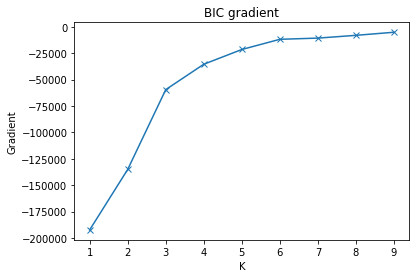

In [22]:
plt.title('BIC gradient')
plt.xlabel('K')
plt.ylabel('Gradient')
plt.plot(bic.keys(), np.gradient(list(bic.values())), 'x-')

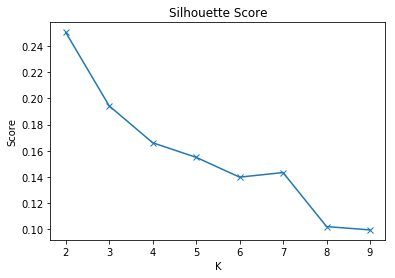

In [23]:
plt.title('Silhouette Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.plot(silhouette.keys(), silhouette.values(), 'x-')

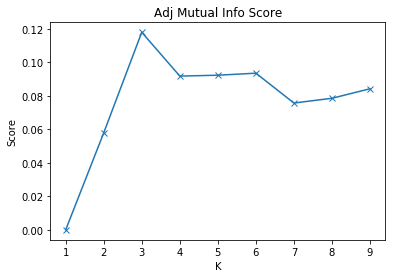

In [24]:
plt.title('Adj Mutual Info Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.plot(mutual_info.keys(), mutual_info.values(), 'x-')

### Validate clustering

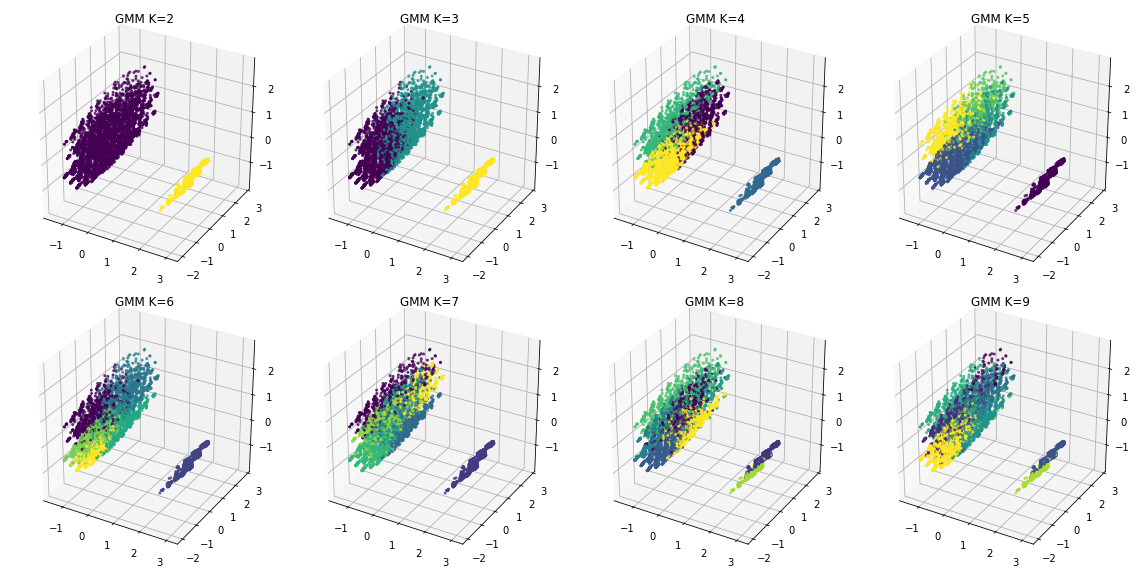

In [25]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('GMM K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### Part2 Dimension reduction
### PCA

In [26]:
dims = X_train.shape[1]
pca = PCA(n_components=dims, random_state=1)

In [27]:
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=45, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
cum_explained_var = find_cumulated_explained_var(pca)

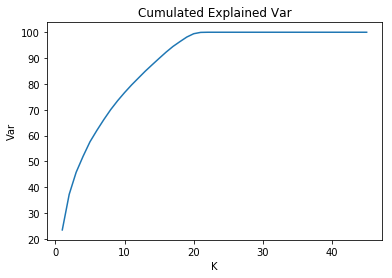

In [29]:
plt.title('Cumulated Explained Var')
plt.xlabel('K'); 
plt.ylabel('Var')
plt.plot(range(1, dims+1), cum_explained_var)

### ICA

In [30]:
%%time

ica_range = np.arange(1, 46)
kurts = {}
for i in ica_range:
    ica = FastICA(n_components=i, whiten=True, random_state=1, tol=.91, max_iter=5000)
    tmp = ica.fit_transform(X_train_scaled)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurts[i] = tmp.abs().mean()

Wall time: 2.98 s


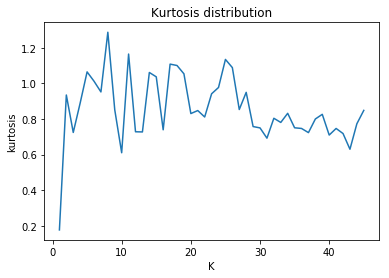

In [31]:
plt.title('Kurtosis distribution')
plt.xlabel('K'); 
plt.ylabel('kurtosis')
plt.plot(kurts.keys(), kurts.values())

In [32]:
max(kurts, key=kurts.get)

8

In [33]:
ica = FastICA(n_components=8, whiten=True, random_state=1, tol=.91, max_iter=5000)
tmp = ica.fit_transform(X_train_scaled)
kurtosistest(tmp, axis=0)

KurtosistestResult(statistic=array([ -31.26603368,  -35.63152216,  239.09406977,  -41.65606148,
       -440.88082914,   13.17681188,  135.55992193,  -40.73565578]), pvalue=array([1.35179716e-214, 4.55471091e-278, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.19327805e-039, 0.00000000e+000, 0.00000000e+000]))

### Random projection

In [34]:
def reconstruction_error(n_components, xtrain):
    results = {}
    for c in n_components:
        srp = SparseRandomProjection(random_state=1, n_components=c)
        xtrain_srp = srp.fit_transform(xtrain)
        recon = np.dot(xtrain_srp, srp.components_.toarray())
        results[c] = np.mean((xtrain - recon)**2)
    return results

In [35]:
srp_range = np.arange(1, 46)
recon_errors = reconstruction_error(srp_range, X_train_scaled)

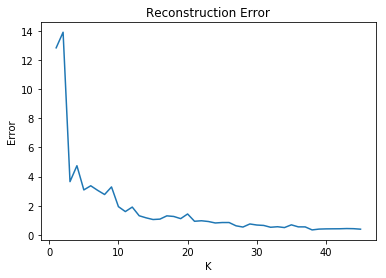

In [36]:
plt.title('Reconstruction Error')
plt.xlabel('K'); 
plt.ylabel('Error')
plt.plot(recon_errors.keys(), recon_errors.values())

In [37]:
min(recon_errors, key=recon_errors.get)

38

### Random forest/Decision tree

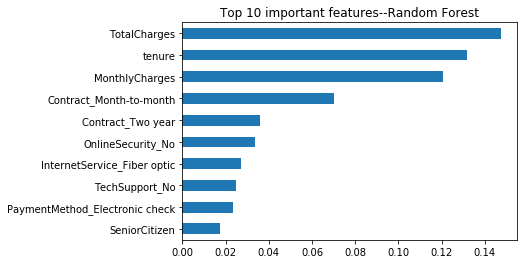

In [38]:
clf = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', n_jobs=-1, random_state=1)
clf.fit(X_train_scaled, y_train)

plt.title('Top 10 important features--Random Forest')
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.gca().invert_yaxis()

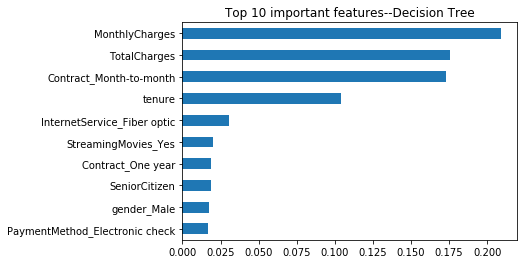

In [39]:
dt = DecisionTreeClassifier(random_state=1, criterion='entropy', class_weight='balanced', max_depth=None)
dt.fit(X_train_scaled, y_train)

plt.title('Top 10 important features--Decision Tree')
feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.gca().invert_yaxis()

### Part3 Clustering on reduced data

In [40]:
# PCA 20 components
pca = PCA(n_components=20, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)

# ICA 8 components
ica = FastICA(n_components=8, random_state=1)
X_train_ica = ica.fit_transform(X_train_scaled)

# SRP 38 components
srp = SparseRandomProjection(n_components=38, random_state=1)
X_train_srp = srp.fit_transform(X_train_scaled)

# Use 4 most important features
X_train_rf = X_train_scaled[:,[1,2,3,36]]

In [41]:
clusters = range(1, 10)
wssse_pca, labels_pca, silhouette_pca, mutual_info_pca = find_km_metrics(X_train_pca, y_train, clusters)
wssse_ica, labels_ica, silhouette_ica, mutual_info_ica = find_km_metrics(X_train_ica, y_train, clusters)
wssse_srp, labels_srp, silhouette_srp, mutual_info_srp = find_km_metrics(X_train_srp, y_train, clusters)
wssse_rf, labels_rf, silhouette_rf, mutual_info_rf = find_km_metrics(X_train_rf, y_train, clusters)

In [42]:
def plot_reduced_data_km(wssse, silhouette, mutual_info, name):
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.title('The Elbow Method--'+name)
    plt.xlabel('K'); 
    plt.ylabel('SSE')
    plt.xticks(clusters)
    plt.plot(wssse.keys(), wssse.values(), 'x-')

    plt.subplot(132)
    plt.title('Silhouette Score--'+name)
    plt.xlabel('K'); 
    plt.ylabel('Score')
    plt.xticks(clusters)
    plt.plot(silhouette.keys(), silhouette.values(), 'x-')

    plt.subplot(133)
    plt.title('Adj Mutual Info Score--'+name)
    plt.xlabel('K'); 
    plt.ylabel('Score')
    plt.xticks(clusters)
    plt.plot(mutual_info.keys(), mutual_info.values(), 'x-')
    
    plt.tight_layout()

### KMeans on PCA data

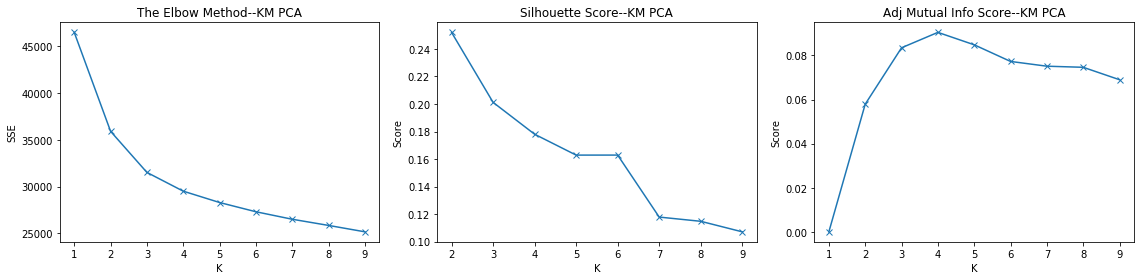

In [43]:
plot_reduced_data_km(wssse_pca, silhouette_pca, mutual_info_pca, 'KM PCA')

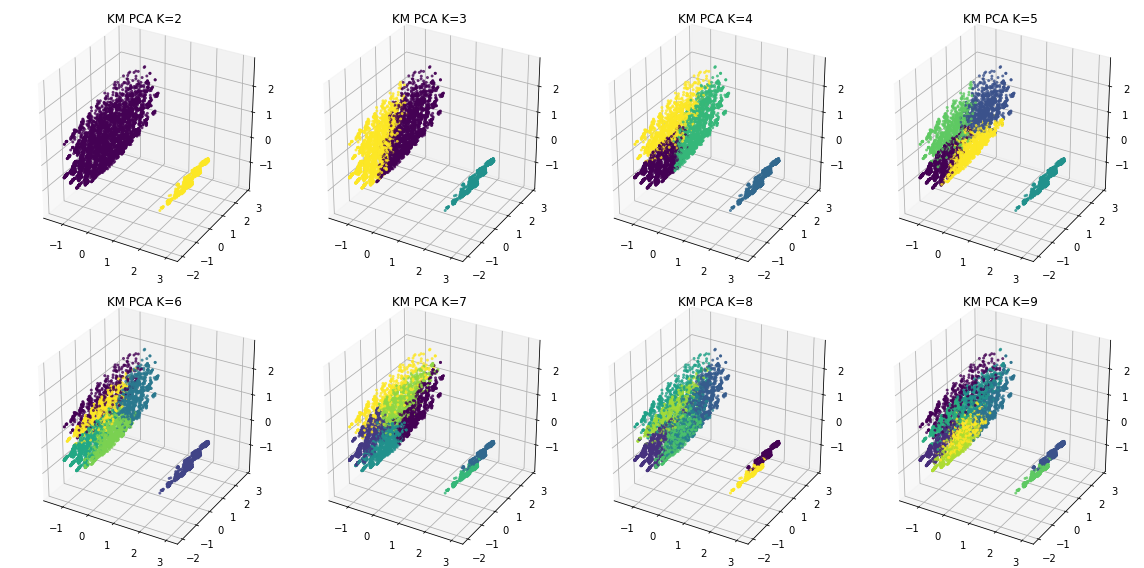

In [44]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('KM PCA K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_pca[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### ICA

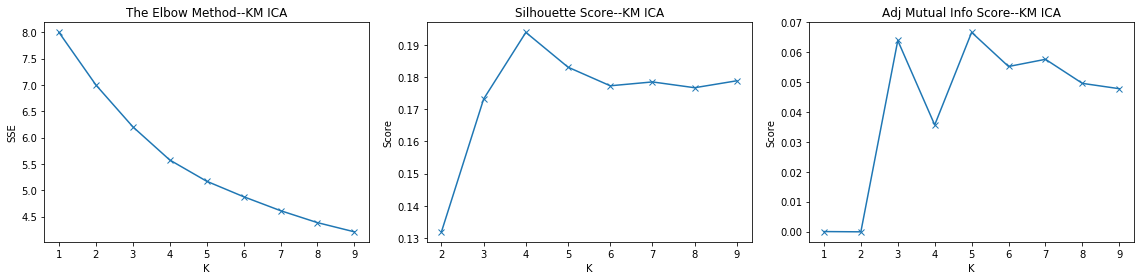

In [45]:
plot_reduced_data_km(wssse_ica, silhouette_ica, mutual_info_ica, 'KM ICA')

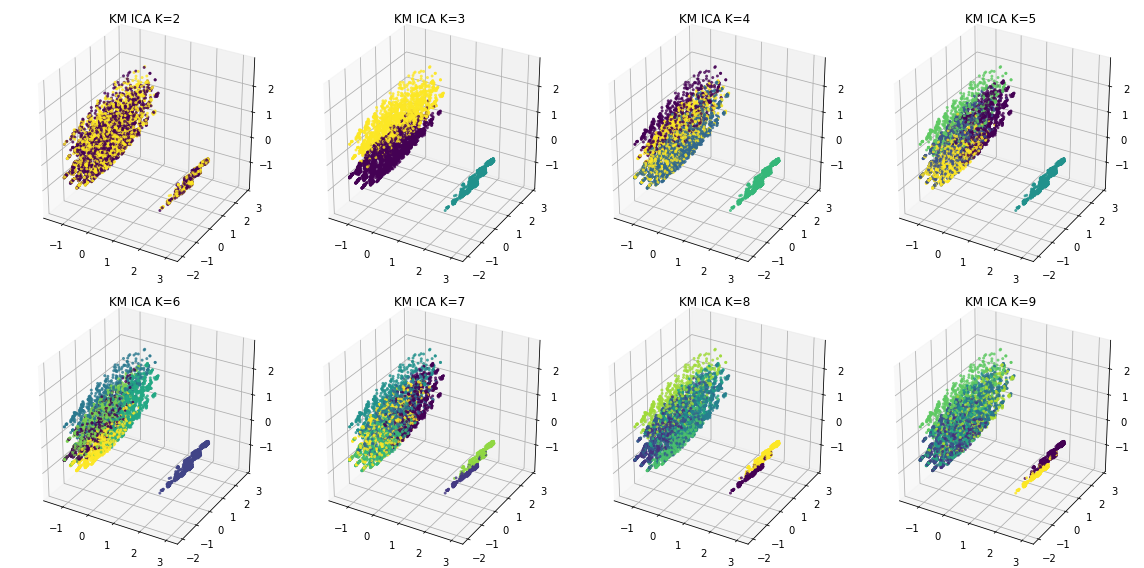

In [46]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('KM ICA K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_ica[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### SRP

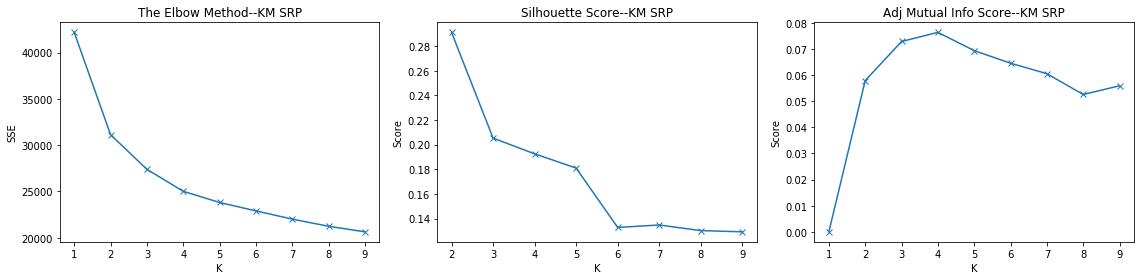

In [47]:
plot_reduced_data_km(wssse_srp, silhouette_srp, mutual_info_srp, 'KM SRP')

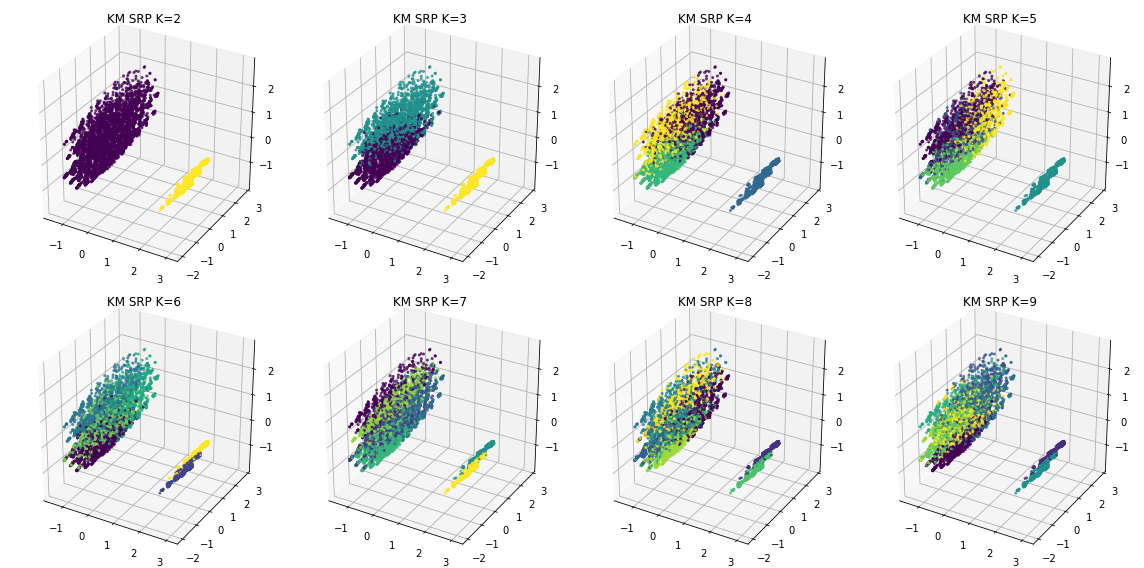

In [48]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('KM SRP K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_srp[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### RF

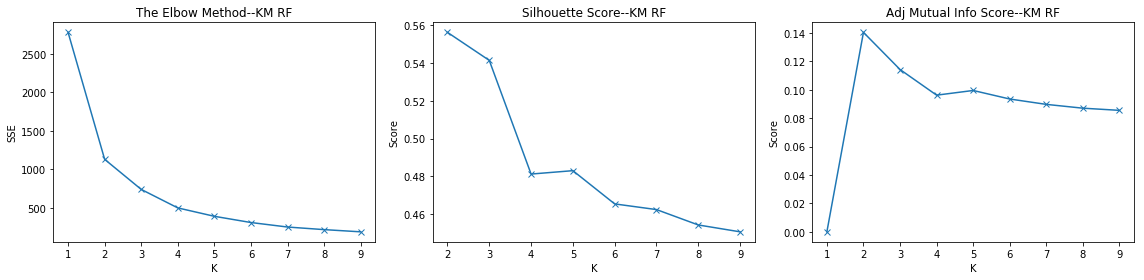

In [49]:
plot_reduced_data_km(wssse_rf, silhouette_rf, mutual_info_rf, 'KM RF')

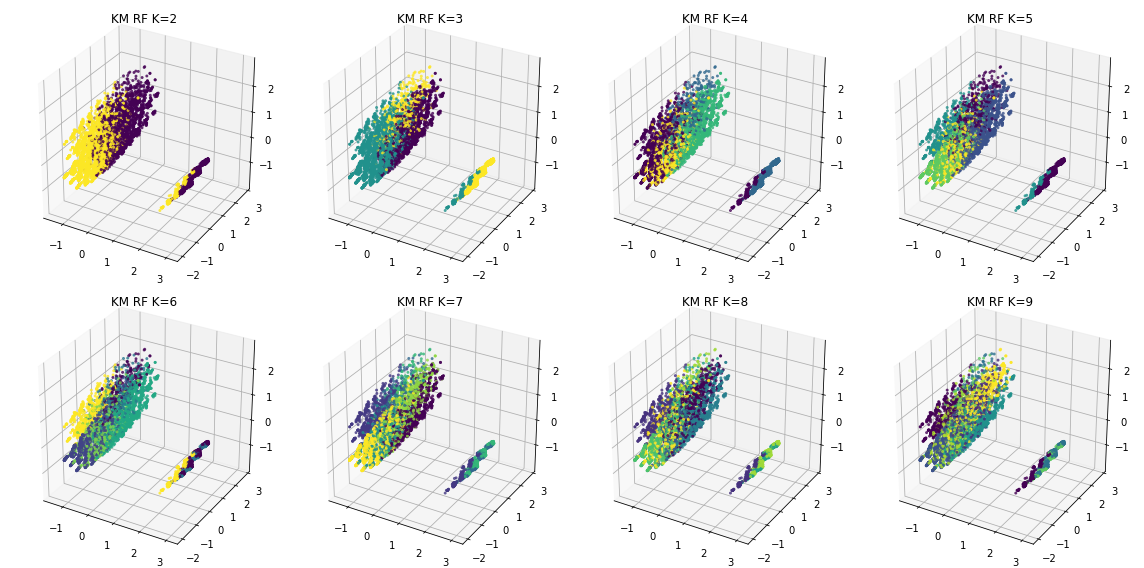

In [50]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('KM RF K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_rf[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### GMM on PCA data

In [51]:
bic_pca, labels_pca, silhouette_pca, mutual_info_pca = find_gmm_metrics(X_train_pca, y_train, clusters)
bic_ica, labels_ica, silhouette_ica, mutual_info_ica = find_gmm_metrics(X_train_ica, y_train, clusters)
bic_srp, labels_srp, silhouette_srp, mutual_info_srp = find_gmm_metrics(X_train_srp, y_train, clusters)
bic_rf, labels_rf, silhouette_rf, mutual_info_rf = find_gmm_metrics(X_train_rf, y_train, clusters)

In [52]:
def plot_reduced_data_gmm(bic, silhouette, mutual_info, name):
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.title('BIC Gradient--'+name)
    plt.xlabel('K')
    plt.ylabel('Gradient')
    plt.plot(bic.keys(), np.gradient(list(bic.values())), 'x-')

    plt.subplot(132)
    plt.title('Silhouette Score--'+name)
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.plot(silhouette.keys(), silhouette.values(), 'x-')

    plt.subplot(133)
    plt.title('Adj Mutual Info Score--'+name)
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.plot(mutual_info.keys(), mutual_info.values(), 'x-')
    
    plt.tight_layout()

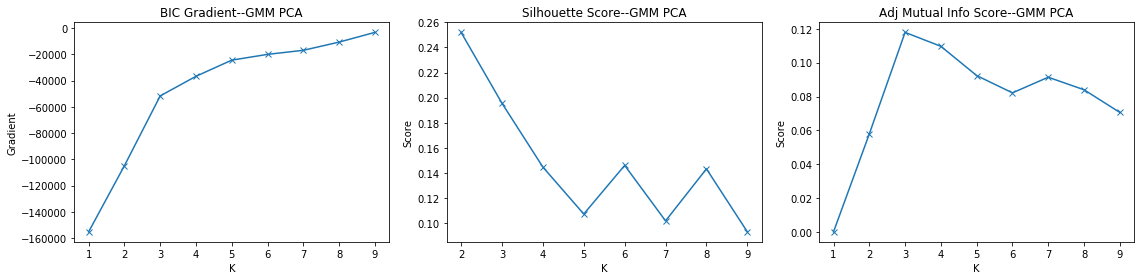

In [53]:
plot_reduced_data_gmm(bic_pca, silhouette_pca, mutual_info_pca, 'GMM PCA')

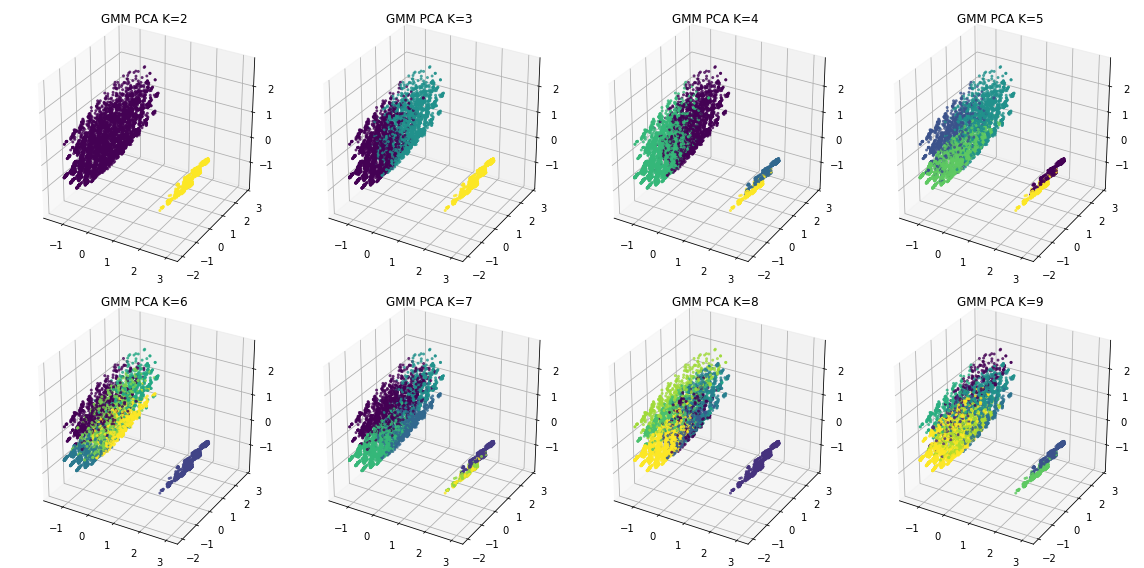

In [54]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('GMM PCA K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_pca[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### ICA

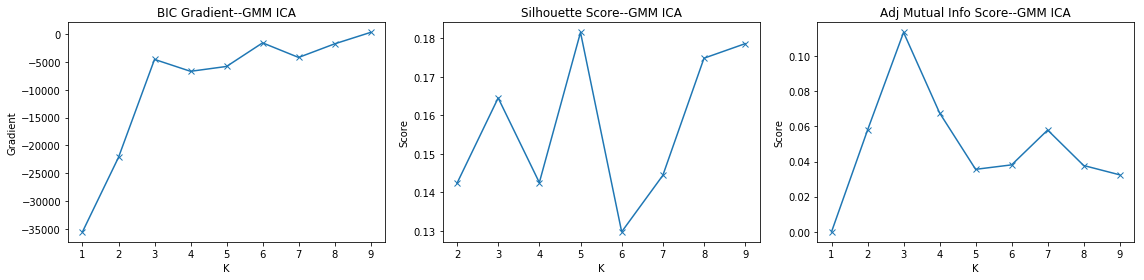

In [55]:
plot_reduced_data_gmm(bic_ica, silhouette_ica, mutual_info_ica, 'GMM ICA')

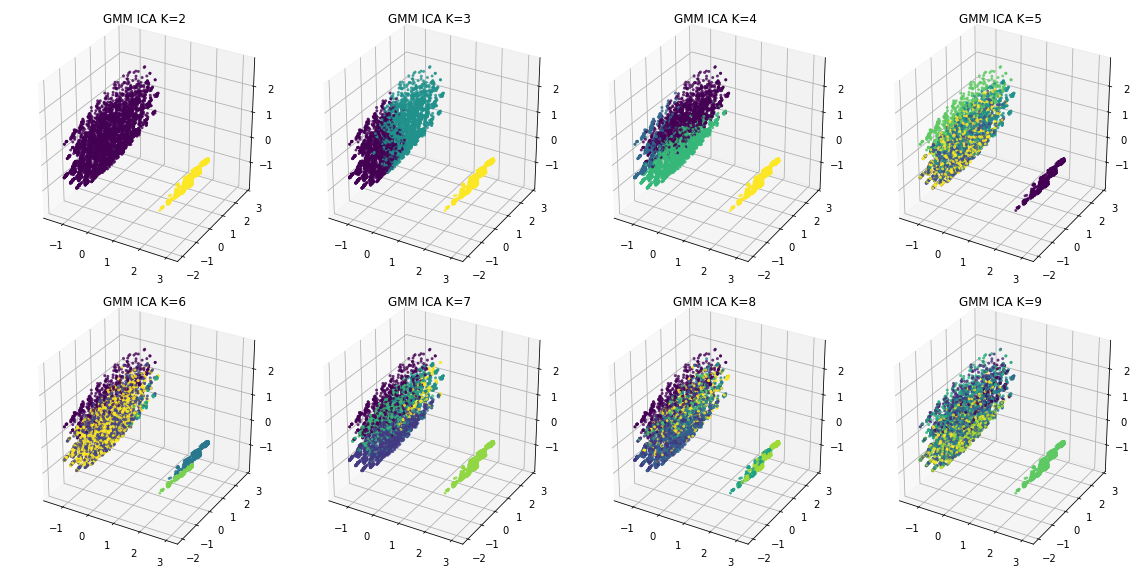

In [56]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('GMM ICA K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_ica[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### SRP

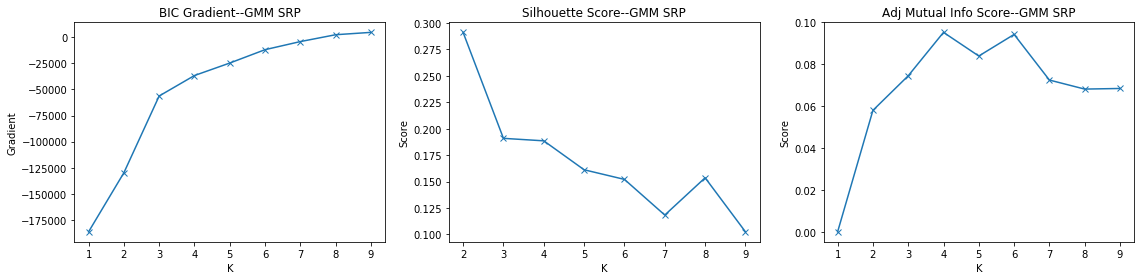

In [57]:
plot_reduced_data_gmm(bic_srp, silhouette_srp, mutual_info_srp, 'GMM SRP')

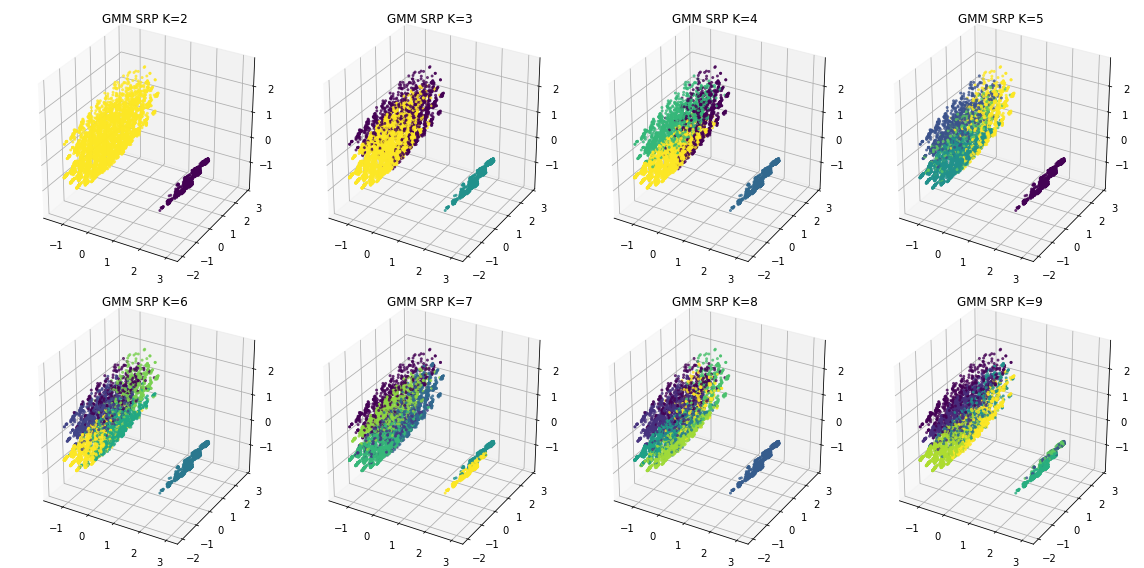

In [58]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('GMM SRP K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_srp[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### RF

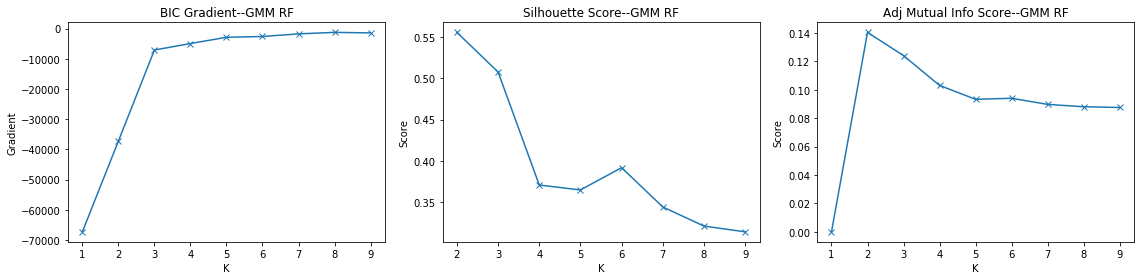

In [59]:
plot_reduced_data_gmm(bic_rf, silhouette_rf, mutual_info_rf, 'GMM RF')

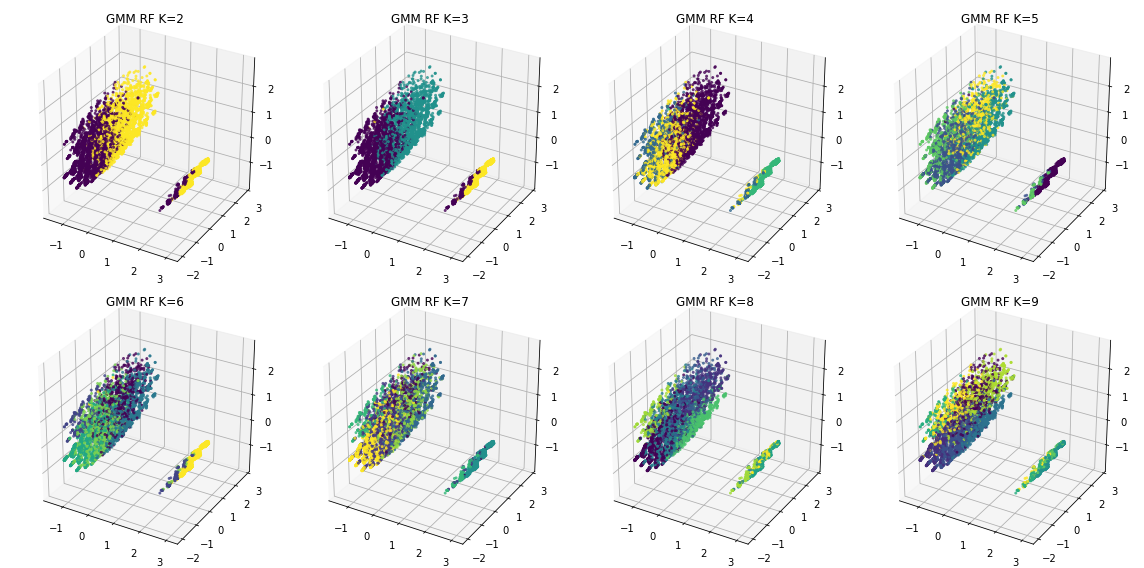

In [60]:
fig = plt.figure(figsize=(16,8))
n = 241
for i in range(2, 10):
    ax = fig.add_subplot(n, projection='3d')
    ax.set_title('GMM RF K='+str(i))
    ax.scatter(features[0], features[1], features[2], c=labels_rf[i], s=4, alpha=0.7, cmap='viridis')
    n += 1
fig.tight_layout()

### Part4 NN on reduced data

In [61]:
X_test_pca = pca.transform(X_test_scaled)
X_test_ica = ica.transform(X_test_scaled)
X_test_srp = srp.transform(X_test_scaled)
X_test_rf = X_test_scaled[:,[1,2,3,36]]

In [62]:
def fit_NN(data):
    wall_time = []
    acc = []
    auc = []
    cm = []
    
    for d in data:
        start_time = timeit.default_timer()
        
        model = MLPClassifier(random_state=1, early_stopping=True, hidden_layer_sizes=(300), verbose=False, 
                              max_iter=500, solver='adam', tol=0.000000001, validation_fraction=0.1, n_iter_no_change=20)
        model.fit(d[0], y_train)
        
        elapsed = timeit.default_timer() - start_time
        wall_time.append(elapsed)
        
        pred = model.predict(d[1])
        acc.append(accuracy_score(y_test, pred))
        auc_train, auc_test = roc_auc_score(y_train, model.predict_proba(d[0])[:,1]),\
                              roc_auc_score(y_test, model.predict_proba(d[1])[:,1])
        auc.append((auc_train, auc_test))
        cm.append(confusion_matrix(y_test, pred))
        
    return wall_time, acc, auc, cm

In [63]:
train = [X_train_scaled, X_train_pca, X_train_ica, X_train_srp, X_train_rf]
test = [X_test_scaled, X_test_pca, X_test_ica, X_test_srp, X_test_rf]
data = zip(train, test)

In [64]:
wall_time, acc, auc, cm = fit_NN(data)

<BarContainer object of 5 artists>

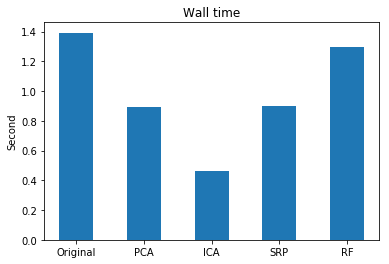

In [65]:
index = range(5)
label = ['Original', 'PCA', 'ICA', 'SRP', 'RF']
plt.xticks(index, label)
plt.title('Wall time')
plt.ylabel('Second')
plt.bar(index, wall_time, width=0.5)

<BarContainer object of 5 artists>

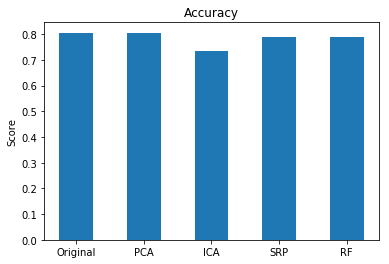

In [66]:
index = range(5)
label = ['Original', 'PCA', 'ICA', 'SRP', 'RF']
plt.xticks(index, label)
plt.title('Accuracy')
plt.ylabel('Score')
plt.bar(index, acc, width=0.5)

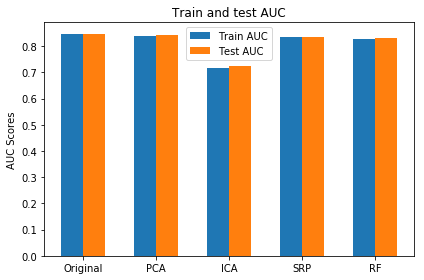

In [67]:
fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.3
opacity = 0.4

bar1 = ax.bar(index, [k[0] for k in auc], bar_width, label='Train AUC')

bar2 = ax.bar(index + bar_width, [k[1] for k in auc], bar_width, label='Test AUC')

ax.set_ylabel('AUC Scores')
ax.set_title('Train and test AUC')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(label)
ax.legend()
fig.tight_layout()

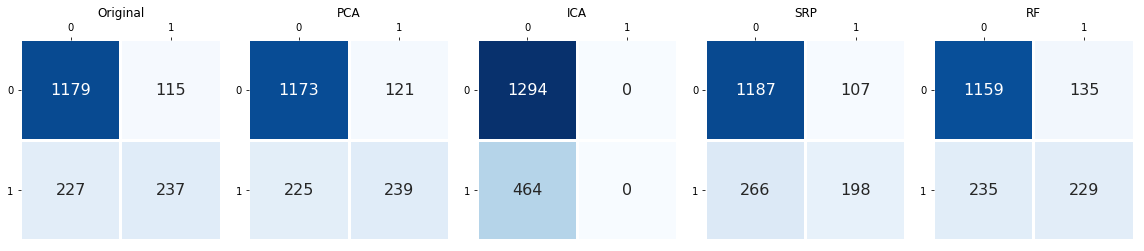

In [68]:
fig = plt.figure(figsize=(16,4))
n = 151

for i in zip(label, cm):
    ax = fig.add_subplot(n)
    ax = sns.heatmap(i[1], annot=True, annot_kws={"size": 16}, fmt='.0f', cmap="Blues", linewidth=2, 
                     square=True, vmin=100, vmax=1300, cbar=False)
    ax.set_title(i[0])
    n += 1
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
fig.tight_layout()

### Part5 NN on reduced data + clustering feature

### KM and GMM for K in range(2, 10)

In [69]:
def appended_data(label, data):
    tmp = pd.get_dummies(pd.Series(label), drop_first=True)
    data = np.append(data, tmp.values, 1)
    return data

In [70]:
def fit_NN_2(clusters, reduced_data, label, modelname):
    acc = {}
    cm = {}
    wall_time = {}
    for i, d in enumerate(reduced_data):
        tmp = []
        tmp_cm = []
        tmp_time = []
        for c in clusters:
            if modelname == 'km':
                model = KMeans(n_clusters=c, random_state=1, n_jobs=-1)
            elif modelname == 'gmm':
                model = GaussianMixture(n_components=c, random_state=1, n_init=10)
            else:
                return 'unknown model'
            train_label = model.fit_predict(d[0])
            test_label = model.fit_predict(d[1])
            train = appended_data(train_label, d[0])
            test = appended_data(test_label, d[1])
            
            start_time = timeit.default_timer()
            mlp = MLPClassifier(random_state=1, early_stopping=True, hidden_layer_sizes=(300), n_iter_no_change=20,
                                  max_iter=500, solver='adam', tol=0.000000001, validation_fraction=0.1)
            mlp.fit(train, y_train)
            elapsed = timeit.default_timer() - start_time
            tmp_time.append(elapsed)
        
            pred = mlp.predict(test)
            tmp.append(accuracy_score(y_test, pred))
            tmp_cm.append(confusion_matrix(y_test, pred))

        acc[label[i]] = tmp
        cm[label[i]] = tmp_cm
        wall_time[label[i]] = tmp_time
    
    return acc, cm, wall_time

In [71]:
clusters = range(2, 10)
label = ['PCA', 'ICA', 'SRP', 'RF']
reduced_data = [(X_train_pca, X_test_pca), (X_train_ica, X_test_ica), (X_train_srp, X_test_srp), (X_train_rf, X_test_rf)]

In [72]:
acc_km, cm_km, wall_time_km = fit_NN_2(clusters, reduced_data, label, 'km')

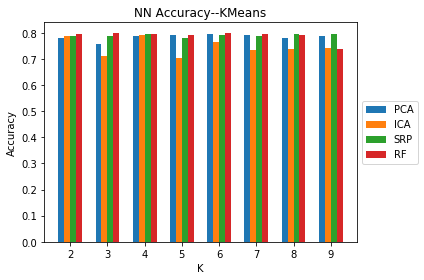

In [73]:
fig, ax = plt.subplots()
index = np.arange(2, 10)
labels = clusters
bar_width = 0.16

bar1 = ax.bar(index, acc_km['PCA'], bar_width, label='PCA')
bar2 = ax.bar(index + bar_width, acc_km['ICA'], bar_width, label='ICA')
bar3 = ax.bar(index + bar_width*2, acc_km['SRP'], bar_width, label='SRP')
bar4 = ax.bar(index + bar_width*3, acc_km['RF'], bar_width, label='RF')

ax.set_ylabel('Accuracy')
ax.set_xlabel('K')
ax.set_title('NN Accuracy--KMeans')
ax.set_xticks(index + 3*bar_width/2)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

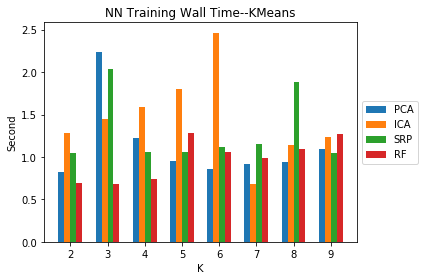

In [74]:
fig, ax = plt.subplots()
index = np.arange(2, 10)
labels = clusters
bar_width = 0.16

bar1 = ax.bar(index, wall_time_km['PCA'], bar_width, label='PCA')
bar2 = ax.bar(index + bar_width, wall_time_km['ICA'], bar_width, label='ICA')
bar3 = ax.bar(index + bar_width*2, wall_time_km['SRP'], bar_width, label='SRP')
bar4 = ax.bar(index + bar_width*3, wall_time_km['RF'], bar_width, label='RF')

ax.set_ylabel('Second')
ax.set_xlabel('K')
ax.set_title('NN Training Wall Time--KMeans')
ax.set_xticks(index + 3*bar_width/2)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [75]:
acc_gmm, cm_gmm, wall_time_gmm = fit_NN_2(clusters, reduced_data, label, 'gmm')

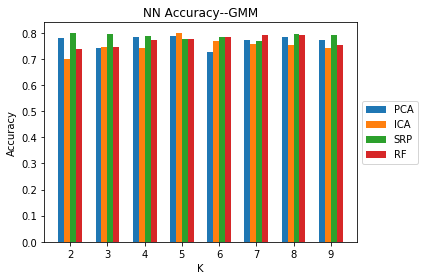

In [76]:
fig, ax = plt.subplots()
index = np.arange(2, 10)
labels = clusters
bar_width = 0.16

bar1 = ax.bar(index, acc_gmm['PCA'], bar_width, label='PCA')
bar2 = ax.bar(index + bar_width, acc_gmm['ICA'], bar_width, label='ICA')
bar3 = ax.bar(index + bar_width*2, acc_gmm['SRP'], bar_width, label='SRP')
bar4 = ax.bar(index + bar_width*3, acc_gmm['RF'], bar_width, label='RF')

ax.set_ylabel('Accuracy')
ax.set_xlabel('K')
ax.set_title('NN Accuracy--GMM')
ax.set_xticks(index + 3*bar_width/2)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

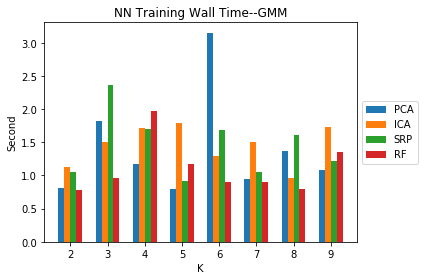

In [77]:
fig, ax = plt.subplots()
index = np.arange(2, 10)
labels = clusters
bar_width = 0.16

bar1 = ax.bar(index, wall_time_gmm['PCA'], bar_width, label='PCA')
bar2 = ax.bar(index + bar_width, wall_time_gmm['ICA'], bar_width, label='ICA')
bar3 = ax.bar(index + bar_width*2, wall_time_gmm['SRP'], bar_width, label='SRP')
bar4 = ax.bar(index + bar_width*3, wall_time_gmm['RF'], bar_width, label='RF')

ax.set_ylabel('Second')
ax.set_xlabel('K')
ax.set_title('NN Training Wall Time--GMM')
ax.set_xticks(index + 3*bar_width/2)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [78]:
best = {'KM PCA K=6':cm_km['PCA'][4], 'KM ICA K=4':cm_km['ICA'][2], 'KM SRP K=9':cm_km['SRP'][7], 'KM RF K=6':cm_km['RF'][4],
        'GMM PCA K=5':cm_gmm['PCA'][3], 'GMM ICA K=5':cm_gmm['ICA'][3], 'GMM SRP K=2':cm_gmm['SRP'][0], 
        'GMM RF K=7':cm_gmm['RF'][5]}

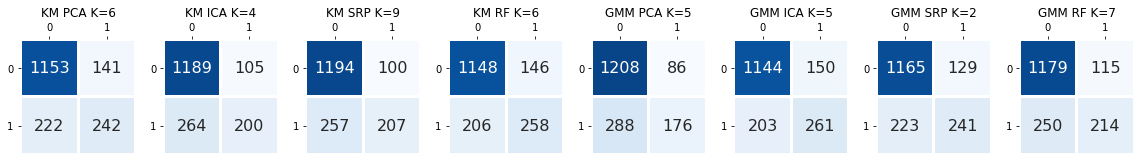

In [79]:
fig = plt.figure(figsize=(16,4))
n = 181

for k in best:
    ax = fig.add_subplot(n)
    ax = sns.heatmap(best[k], annot=True, annot_kws={"size": 16}, fmt='.0f', cmap="Blues", linewidth=2, 
                     square=True, vmin=100, vmax=1300, cbar=False)
    ax.set_title(k)
    n += 1
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
fig.tight_layout()